# Tabular Playground Series Sep 2022

For this challenge, you will be predicting a full year worth of sales for 4 items from two competing stores located in six different countries. This dataset is completely fictional, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc. You are given the challenging task of predicting book sales during the year 2021.

#### Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV , cross_val_score ,cross_validate

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
train_data_row, train_data_col = train_data.shape
print('Total rows: ', train_data_row)
print('Total columns: ', train_data_col)

Total rows:  70128
Total columns:  6


In [4]:
train_data.head()

,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [5]:
train_data.tail()

,row_id,date,country,store,product,num_sold
70123,70123,2020-12-31,Spain,KaggleMart,Kaggle for Kids: One Smart Goose,614
70124,70124,2020-12-31,Spain,KaggleRama,Kaggle Advanced Techniques,215
70125,70125,2020-12-31,Spain,KaggleRama,Kaggle Getting Started,158
70126,70126,2020-12-31,Spain,KaggleRama,Kaggle Recipe Book,135
70127,70127,2020-12-31,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,202


## Data Understanding

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    70128 non-null  int64 
 1   date      70128 non-null  object
 2   country   70128 non-null  object
 3   store     70128 non-null  object
 4   product   70128 non-null  object
 5   num_sold  70128 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [7]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [8]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,70128.0,35063.500000,20244.354176,0.0,17531.75,35063.5,52595.25,70127.0
num_sold,70128.0,194.296986,126.893874,19.0,95.00,148.0,283.00,986.0


In [9]:
print("duplicated data :", train_data.duplicated().sum())
print("null data : ", train_data.isnull().sum().sum())

duplicated data : 0
null data :  0


In [10]:
for col in train_data.columns:
    print(col, len(train_data[col].unique()))

row_id 70128
date 1461
country 6
store 2
product 4
num_sold 699


### EDA

Text(0.5, 1.0, 'Total Store Sales')

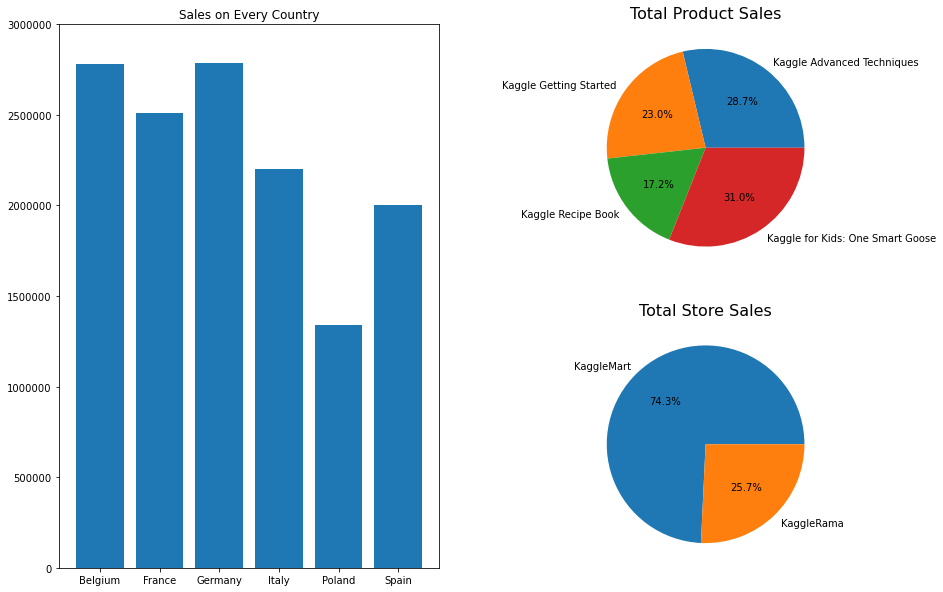

In [11]:
sold_product = train_data.groupby(['product'])['num_sold'].sum()
sold_store = train_data.groupby(['store'])['num_sold'].sum()
sold_country = train_data.groupby(['country'])['num_sold'].sum()

fig = plt.figure(figsize=(15,10))
fig.set_facecolor('white')

ax1 = fig.add_subplot(1, 2, 1)
ax1.bar(sold_country.keys(), sold_country.values)
ax1.set_title('Sales on Every Country')
ax1.ticklabel_format(style='plain', axis='y')
ax1.set_ylim(0, 3e6)

ax2 = fig.add_subplot(2, 2, 2)
ax2.pie(sold_product.values, labels=sold_product.keys(), autopct="%.1f%%")
ax2.set_title('Total Product Sales', fontsize=16)

ax3 = fig.add_subplot(2, 2, 4)
ax3.pie(sold_store.values, labels=sold_store.keys(), autopct="%.1f%%")
ax3.set_title('Total Store Sales', fontsize=16)

Text(0.5, 1.0, 'Product Sales by Store')

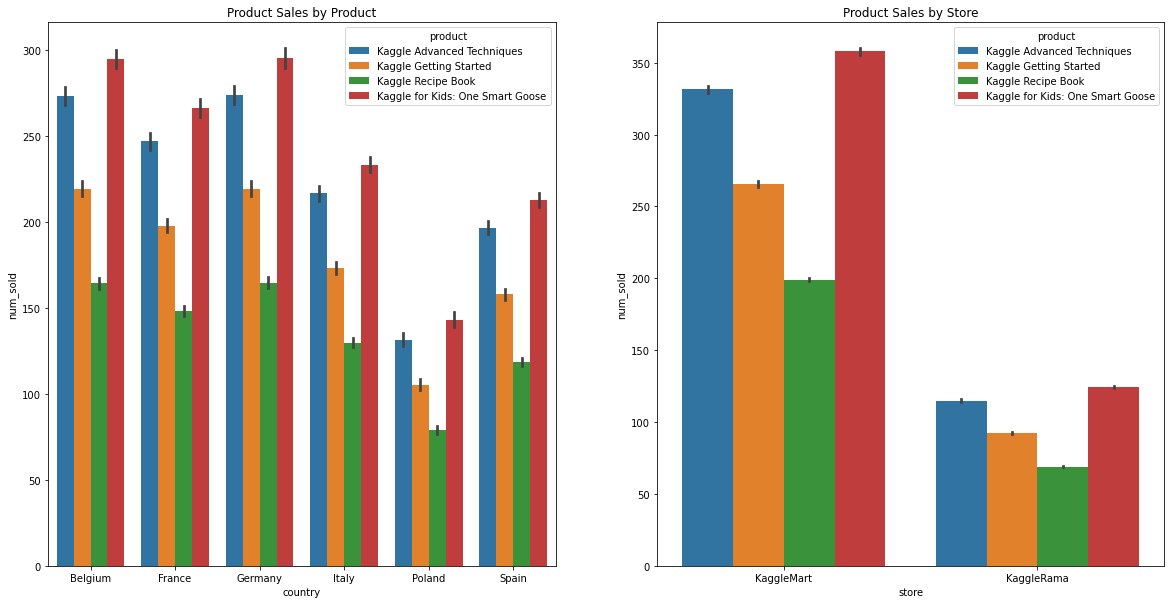

In [12]:
fig = plt.figure(figsize=(20,10))
fig.set_facecolor('white')

ax1 = fig.add_subplot(1, 2, 1)
sns.barplot(data=train_data, x='country', y='num_sold', hue='product')
ax1.set_title('Product Sales by Product')

ax2 = fig.add_subplot(1, 2, 2)
sns.barplot(data=train_data, x='store', y='num_sold', hue='product')
ax2.set_title("Product Sales by Store")

In [13]:
monthly_sales = train_data.groupby(['country', 'store', 'product', pd.Grouper(key='date', freq='MS')])['num_sold'].sum().reset_index()
monthly_sales

,country,store,product,date,num_sold
0,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-01-01,13345
1,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-02-01,12556
2,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-03-01,14137
3,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-04-01,14575
4,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-05-01,14338
...,...,...,...,...,...
2299,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,2020-08-01,4578
2300,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,2020-09-01,4254
2301,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,2020-10-01,4644
2302,Spain,KaggleRama,Kaggle for Kids: One Smart Goose,2020-11-01,4437


Text(0.5, 1.0, 'Monthly sales by Store')

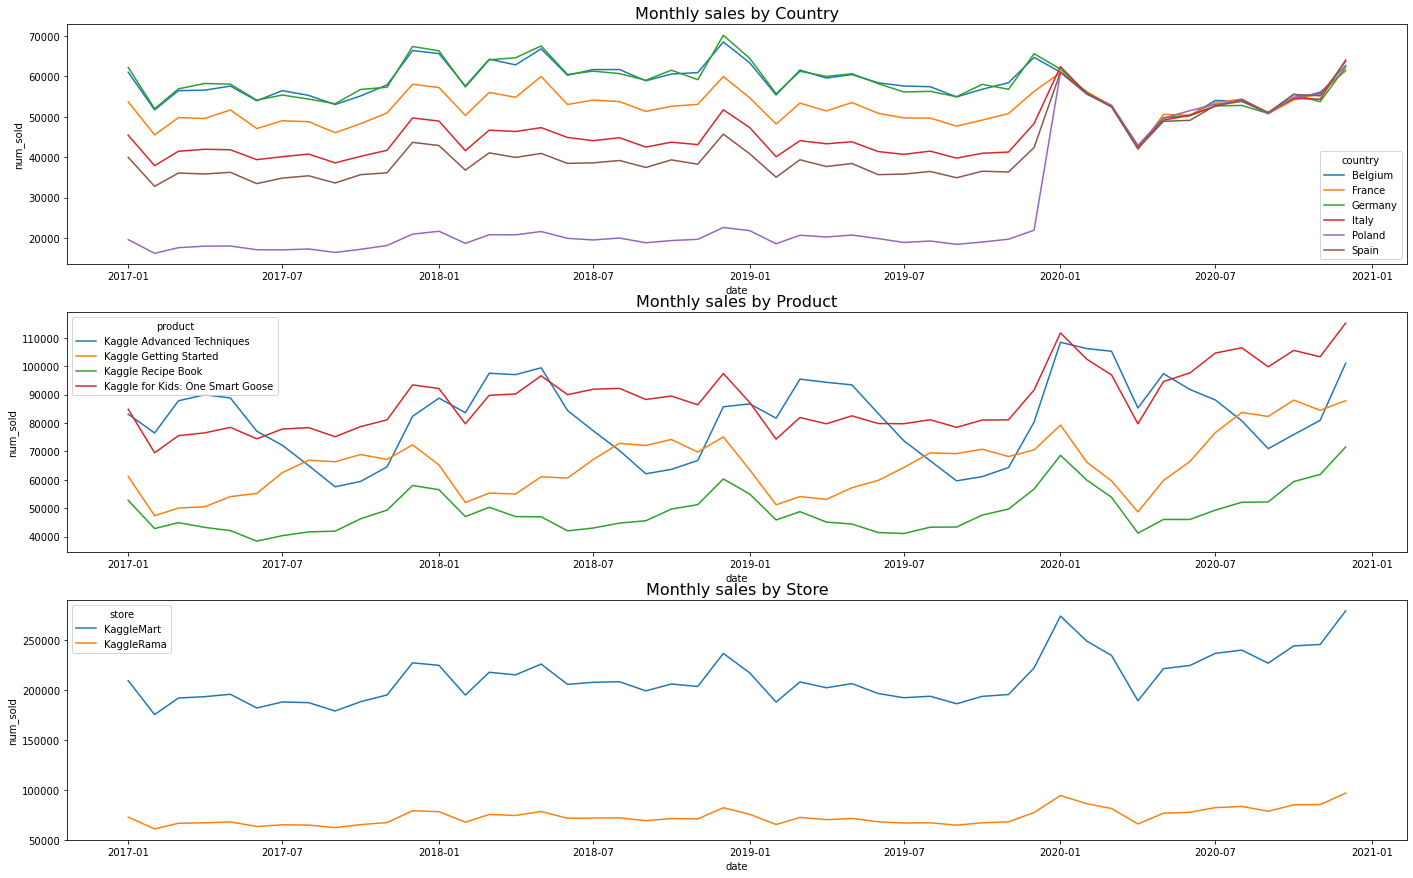

In [14]:
monthly_sales_country = monthly_sales.groupby(['country','date'])['num_sold'].sum().reset_index()
monthly_sales_product = monthly_sales.groupby(['product', 'date'])['num_sold'].sum().reset_index()
monthly_sales_store = monthly_sales.groupby(['store', 'date'])['num_sold'].sum().reset_index()

fig = plt.figure(figsize=(24, 15))
fig.set_facecolor('white')

ax1 = fig.add_subplot(3, 1, 1)
sns.lineplot(data=monthly_sales_country, x='date', y='num_sold', hue='country')
ax1.set_title("Monthly sales by Country", fontsize= 16)

ax2 = fig.add_subplot(3, 1, 2)
sns.lineplot(data=monthly_sales_product, x='date', y='num_sold', hue='product')
ax2.set_title("Monthly sales by Product", fontsize= 16)

ax3 = fig.add_subplot(3, 1, 3)
sns.lineplot(data=monthly_sales_store, x='date', y='num_sold', hue='store')
ax3.set_title("Monthly sales by Store", fontsize= 16)

Text(0.5, 1.0, 'Time Series of Sales by Store')

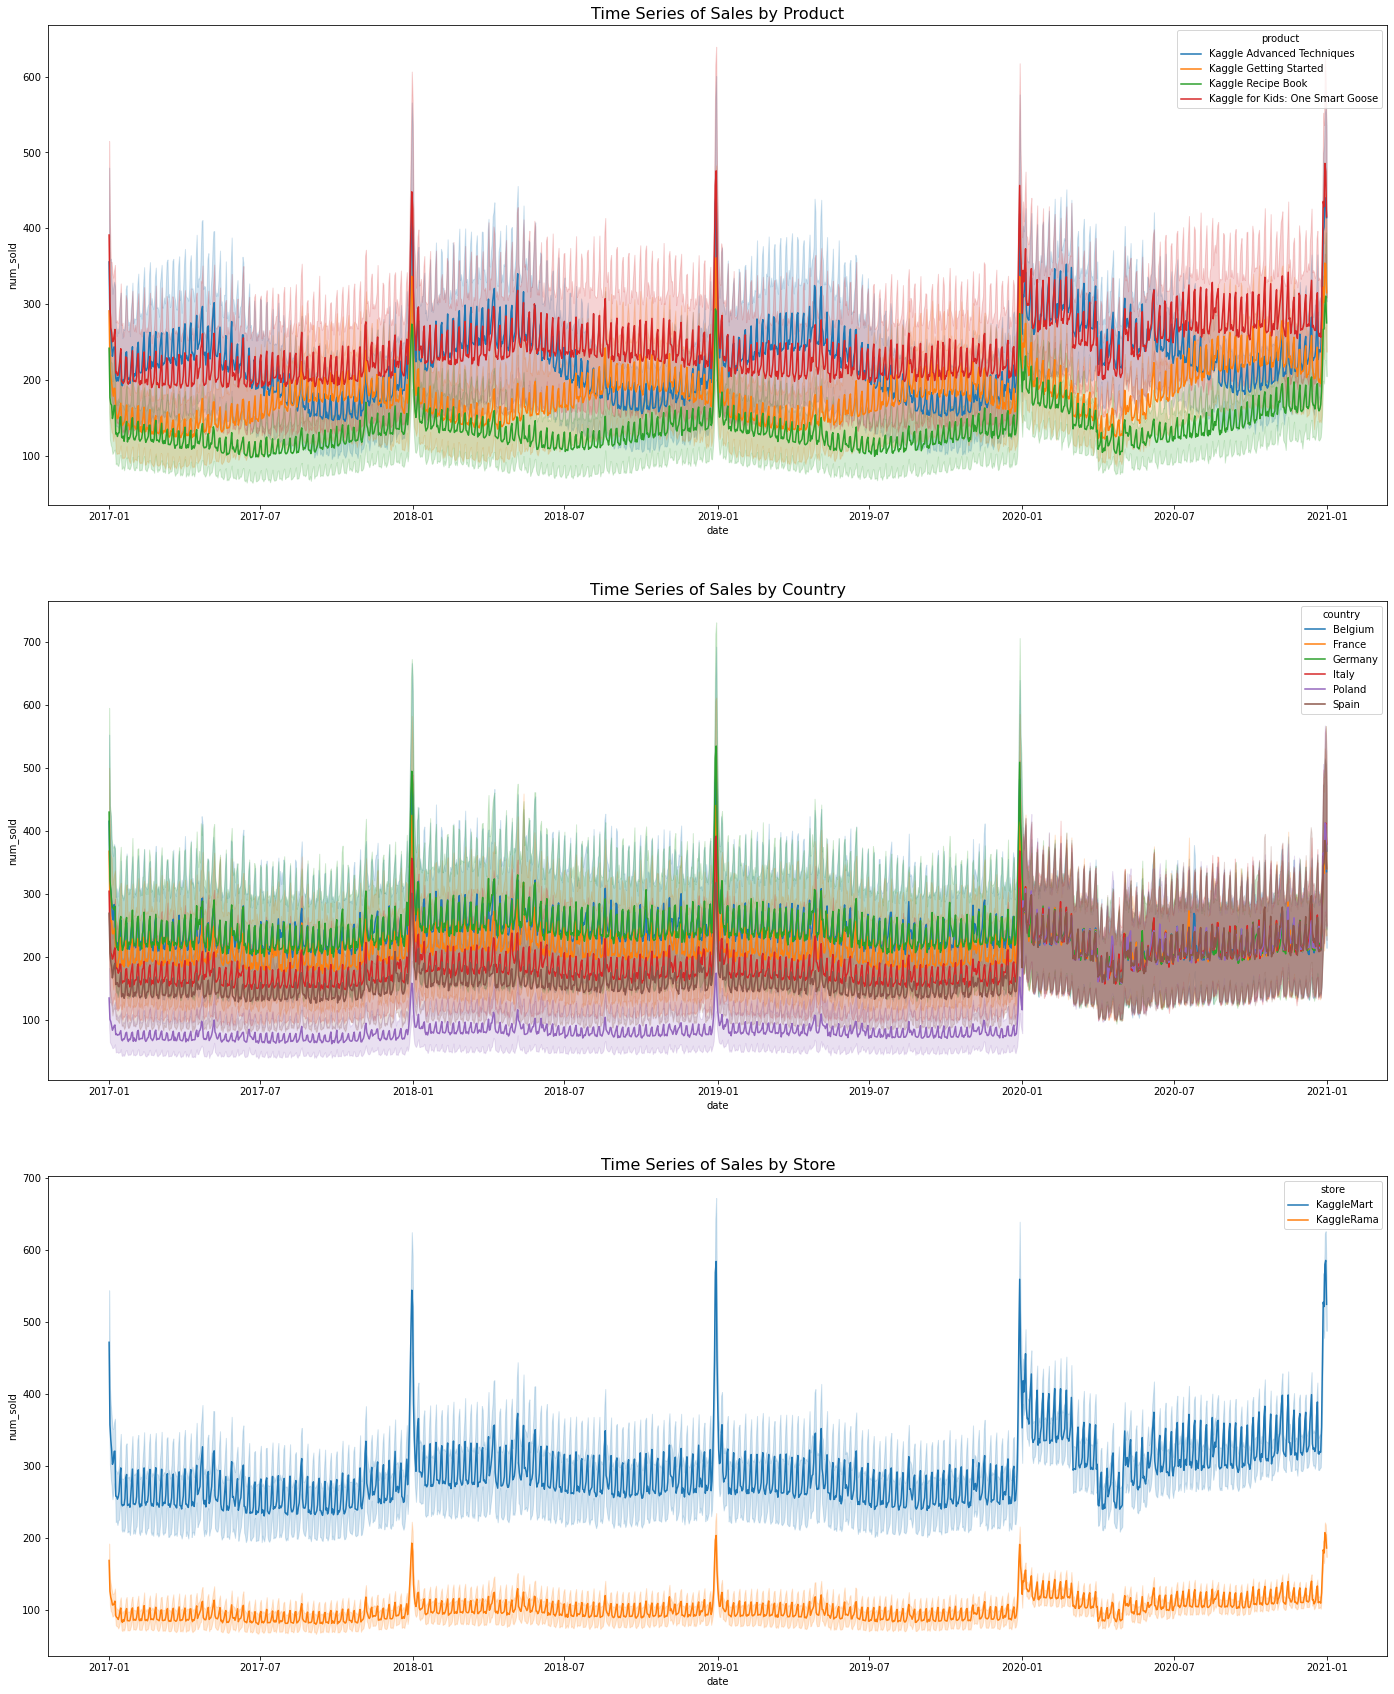

In [16]:
fig = plt.figure(figsize=(24,30))
fig.set_facecolor('white')

ax1 = fig.add_subplot(3, 1, 1)
sns.lineplot(data=train_data,x='date',y='num_sold',hue='product')
ax1.set_title("Time Series of Sales by Product",fontsize=16)

ax1 = fig.add_subplot(3, 1, 2)
sns.lineplot(data=train_data,x='date',y='num_sold',hue='country')
ax1.set_title("Time Series of Sales by Country",fontsize=16)

ax1 = fig.add_subplot(3, 1, 3)
sns.lineplot(data=train_data,x='date',y='num_sold',hue='store')
ax1.set_title("Time Series of Sales by Store",fontsize=16)

## Preprocessing

In [17]:
# Format date col

def format_date(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayOfYear'] = df['date'].dt.dayofyear
    df['weekday'] = df['date'].dt.weekday
    return df

train_data = format_date(train_data)
test_data = format_date(test_data)

In [18]:
le = LabelEncoder()
cols = ['country', 'store', 'product']
for col in cols:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])

In [19]:
train_data = train_data.drop(['date', 'row_id'], axis=1)
test_data = test_data.drop(['date', 'row_id'], axis=1)

In [20]:
train_data.head()

,country,store,product,num_sold,year,month,day,dayOfYear,weekday
0,0,0,0,663,2017,1,1,1,6
1,0,0,1,615,2017,1,1,1,6
2,0,0,2,480,2017,1,1,1,6
3,0,0,3,710,2017,1,1,1,6
4,0,1,0,240,2017,1,1,1,6


In [21]:
test_data.head()

,country,store,product,year,month,day,dayOfYear,weekday
0,0,0,0,2021,1,1,1,4
1,0,0,1,2021,1,1,1,4
2,0,0,2,2021,1,1,1,4
3,0,0,3,2021,1,1,1,4
4,0,1,0,2021,1,1,1,4


## Modeling

In [22]:
X = train_data.drop('num_sold', axis=1)
y = train_data['num_sold'] 

In [23]:
lgb = LGBMRegressor(random_state=42, boosting_type='dart')
cb = CatBoostRegressor(random_state=42, verbose=0)
lr = LinearRegression()

models = [lgb, cb, lr]

In [24]:
def get_scores(cv_scores):
    scores = np.zeros(test_data.shape[0])
    for estimator in cv_scores['estimator']:
        scores += estimator.predict(test_data)
    scores /= len(cv_scores['estimator'])
    return scores

In [25]:
def smape(a, f):
    # Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

smape_score = make_scorer(smape, greater_is_better=False)

scalar = StandardScaler()

res = pd.DataFrame()
row_number = 0
results = []
names = []
prob_scores = []

for model in models:
    model_name=model.__class__.__name__
    pipeline = Pipeline([('transformer', scalar), ('estimator', model)])
    print(model_name, 'training')

    cv_results = cross_validate(pipeline, X, y, cv=42, scoring=smape_score, return_train_score=True, return_estimator=True, n_jobs=-1)

    res.loc[row_number,'Model Name'] = model_name
    res.loc[row_number, 'Train Score Mean'] = cv_results['train_score'].mean()
    res.loc[row_number, 'Test Score Mean'] = cv_results['test_score'].mean()
    res.loc[row_number, 'Fit Time Mean'] = cv_results['fit_time'].mean()
    results.append(cv_results)
    names.append(model_name)
    prob_scores.append(get_scores(cv_results))

    row_number+=1

LGBMRegressor training
CatBoostRegressor training
LinearRegression training


In [26]:
display(res.style.background_gradient())

,Model Name,Train Score Mean,Test Score Mean,Fit Time Mean
0,LGBMRegressor,-11.356153,-11.911337,2.349572
1,CatBoostRegressor,-4.545609,-5.595847,28.574385
2,LinearRegression,-32.424895,-32.607023,0.152751


#### Using CatBoostRegressor

In [27]:
## Score: 6.09791

params_cb = {
    'depth'         : [8, 10],
    'learning_rate' : [0.1],
    'iterations'    : [50, 100],
    'random_state'  : [42], 
    'verbose'       : [0],
    }

grid_search_cb = GridSearchCV(
    estimator=cb,
    param_grid=params_cb,
    cv = 42,
    scoring=smape_score,
    n_jobs = -1
).fit(X, y)

cb_best = grid_search_cb.best_estimator_
print('CB Best Params',grid_search_cb.best_params_)

CB Best Params {'depth': 10, 'iterations': 100, 'learning_rate': 0.1, 'random_state': 42, 'verbose': 0}


In [28]:
pipeline = Pipeline([('transformer', scalar), ('estimator', cb_best)])
cv_results = cross_validate(pipeline, X, y, cv=5, scoring=smape_score, return_train_score=True, return_estimator=True, n_jobs=-1)
np.mean(cv_results['test_score'])

-11.928928505674998

In [29]:
scores = np.zeros(test_data.shape[0])
for estimator in cv_results['estimator']:
    scores += estimator.predict(test_data)
    
scores /= len(cv_results['estimator'])

In [30]:
submission["num_sold"] = scores
submission.head()

,row_id,num_sold
0,70128,452.243775
1,70129,357.376204
2,70130,309.019029
3,70131,486.330023
4,70132,161.599881


In [31]:
submission.to_csv("submission.csv", index = False)